<a href="https://colab.research.google.com/github/faizanhemotra/CE888/blob/main/Project/Emotion_ELECTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data

In [ ]:
import numpy as np
import re
import requests

In [ ]:
def shape_data(feature, label):
    '''Returns number of rows for feature and label'''
    return len(feature.splitlines()), len(label.splitlines())

In [ ]:
emotion_train_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt'
emotion_train = requests.get(emotion_train_url)
emotion_train_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt'
emotion_train_labels = requests.get(emotion_train_labels_url)
print('Emotion Training, Label')
shape_data(emotion_train.text, emotion_train_labels.text)

Emotion Training, Label


(3257, 3257)

In [ ]:
emotion_val_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt'
emotion_val = requests.get(emotion_val_url)
emotion_val_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt'
emotion_val_labels = requests.get(emotion_val_labels_url)
print('Emotion Validation, Label')
shape_data(emotion_val.text, emotion_val_labels.text)

Emotion Validation, Label


(374, 374)

In [ ]:
emotion_test_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt'
emotion_test = requests.get(emotion_test_url)
emotion_test_labels_url = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt'
emotion_test_labels = requests.get(emotion_test_labels_url)
print('Emotion Test, Label')
shape_data(emotion_test.text, emotion_test_labels.text)

Emotion Test, Label


(1421, 1421)

##Labels

In [ ]:
emotion_train_distr = list()
for label in emotion_train_labels.text.splitlines():
    emotion_train_distr.append(int(label))

In [ ]:
emotion_val_distr = list()
for label in emotion_val_labels.text.splitlines():
    emotion_val_distr.append(int(label))
    
emotion_test_distr = list()
for label in emotion_test_labels.text.splitlines():
    emotion_test_distr.append(int(label))

In [ ]:
labels = list(set(emotion_train_distr))
print(labels)

[0, 1, 2, 3]


In [ ]:
def linkremover(text):
    '''Removes t.co and instagram.com links from the data'''
    tco = r'https?://t.co/[\w]{10}'
    insta = r'https?://(www.)?instagram.com/p/[-\w]{11}/?'
    if (re.findall(tco + '|' + insta, text) != []):
        final = re.sub(tco + '|' + insta, '', text)
        return final
    else:
        print('No links')
    return text

In [ ]:
emotion_tr = linkremover(emotion_train.text)
emotion_v = linkremover(emotion_val.text)
emotion_te = linkremover(emotion_test.text)

No links
No links
No links


In [ ]:
import os
import torch
hftransformers = os.path.exists('/content/transformers')
if hftransformers:
  print('transformers already downloaded ')
else:
  !git clone https://github.com/huggingface/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 70072, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 70072 (delta 87), reused 125 (delta 61), pack-reused 69912
Receiving objects: 100% (70072/70072), 53.20 MiB | 29.78 MiB/s, done.
Resolving deltas: 100% (49655/49655), done.


In [ ]:
cd transformers

/content/transformers


In [ ]:
if hftransformers:
  print('transformers already downloaded ')
else:
  !pip3 install --upgrade .

Processing /content/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 870kB 20.4MB/s 
     |████████████████████████████████| 3.3MB 49.3MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2110169 sha256=869fa7b1b45df94630e4f5a28e17353dc9ffb6c260b246f89ad1a278f5ffa462
  Stored in directory: /tmp/pip-ephem-wheel-cache-5zp7t6b2/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e75c75099364ac80460eeae878587d9773dd2abe455ae4b44263d4037cc6ceb5
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import importlib
emoji = importlib.util.find_spec("emoji")
found = emoji is not None
if found:
  print('emoji package already exists')
else:
  !pip3 install emoji

     |████████████████████████████████| 133kB 20.9MB/s 


## Tokenizing

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator', use_fast=False)

In [ ]:
torch.manual_seed(1)
np.random.seed(1)

In [ ]:
train_encodings = tokenizer(emotion_tr.splitlines(), truncation=True, padding=True)
valid_encodings = tokenizer(emotion_v.splitlines(), truncation=True, padding=True)
test_encodings = tokenizer(emotion_te.splitlines(), truncation=True, padding=True)

In [ ]:
class Emotion(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = Emotion(train_encodings, emotion_train_distr)
valid_dataset = Emotion(valid_encodings, emotion_val_distr)
test_dataset = Emotion(test_encodings, emotion_test_distr)

##Training

In [ ]:
from sklearn.metrics import f1_score
from transformers import ElectraForSequenceClassification, Trainer, TrainingArguments

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='macro')
    return {
        'f1': f1
    }

model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', cache_dir='cache/', num_labels=len(labels))
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total # of training epochs
    per_device_train_batch_size=12,  # batch size per device during training
    per_device_eval_batch_size=12,   # batch size for evaluation
    evaluation_strategy = "epoch",
    disable_tqdm=False,
    load_best_model_at_end=True,
    save_total_limit=7,
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_steps=8,
    logging_dir='./logs',            # directory for storing logs
    dataloader_num_workers = 2,
    run_name='roberta-classification'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
if device == 'cuda':
  !nvidia-smi

Fri Apr 16 16:17:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |   1106MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,1.236200,1.247837,0.149813
2,1.032400,0.807926,0.705014
3,0.557700,0.690955,0.733727
4,0.476000,0.712785,0.718765
5,0.311700,0.772943,0.689807


TrainOutput(global_step=1360, training_loss=0.7880810594734023, metrics={'train_runtime': 231.8073, 'train_samples_per_second': 5.867, 'total_flos': 82085129020560.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 2748493824, 'init_mem_gpu_alloc_delta': 54203904, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 75542528, 'train_mem_gpu_alloc_delta': 216812032, 'train_mem_cpu_peaked_delta': 16384, 'train_mem_gpu_peaked_delta': 131124224})

In [ ]:
torch.save(model.state_dict(), 'model_emotion.pth')

## Evaluations

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    conf_mat: confusion matrix
    classes: names of classes to be annotated
    normalize: [True/False] whether to normalise by column
    """
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Validation Dataset

In [ ]:
val_pred = trainer.predict(valid_dataset)
val_pred.metrics

{'test_f1': 0.733726945234232,
 'test_loss': 0.690954864025116,
 'test_mem_cpu_alloc_delta': 114688,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_gpu_peaked_delta': 9228288,
 'test_runtime': 0.9405,
 'test_samples_per_second': 397.65}

In [ ]:
validation_pred = []
for i in range(len(val_pred.predictions)):
  validation_pred.append(np.argmax(val_pred.predictions[i]))

Normalized confusion matrix


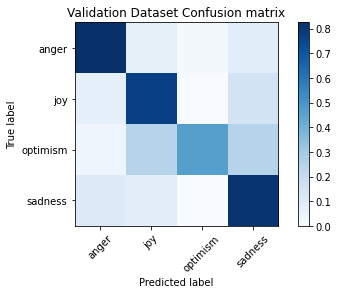

In [ ]:
cnf_matrix = confusion_matrix(emotion_val_distr, validation_pred)
plot_confusion_matrix(cnf_matrix, classes=['anger', 'joy', 'optimism', 'sadness'], normalize=True,
                      title='Validation Dataset Confusion matrix')

In [ ]:
print(classification_report(emotion_val_distr, validation_pred, digits=5))

              precision    recall  f1-score   support

           0    0.88000   0.82500   0.85161       160
           1    0.75000   0.77320   0.76142        97
           2    0.81250   0.46429   0.59091        28
           3    0.66667   0.80899   0.73096        89

    accuracy                        0.78075       374
   macro avg    0.77729   0.71787   0.73373       374
weighted avg    0.79046   0.78075   0.77999       374



### Test Dataset

In [ ]:
te_pred = trainer.predict(test_dataset)
te_pred.metrics

{'test_f1': 0.7408710579993132,
 'test_loss': 0.6652125716209412,
 'test_mem_cpu_alloc_delta': 86016,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_gpu_peaked_delta': 12263424,
 'test_runtime': 3.6441,
 'test_samples_per_second': 389.947}

In [ ]:
test_pred = []
for i in range(len(te_pred.predictions)):
  test_pred.append(np.argmax(te_pred.predictions[i]))

Normalized confusion matrix


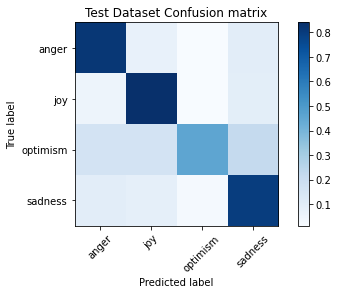

In [ ]:
cnf_matrix = confusion_matrix(emotion_test_distr, test_pred)
plot_confusion_matrix(cnf_matrix, classes=['anger', 'joy', 'optimism', 'sadness'], normalize=True,
                      title='Test Dataset Confusion matrix')

In [ ]:
print(classification_report(emotion_test_distr, test_pred, digits=5))

              precision    recall  f1-score   support

           0    0.85714   0.81720   0.83670       558
           1    0.76396   0.84078   0.80053       358
           2    0.74667   0.45528   0.56566       123
           3    0.72619   0.79843   0.76060       382

    accuracy                        0.78677      1421
   macro avg    0.77349   0.72793   0.74087      1421
weighted avg    0.78890   0.78677   0.78367      1421



## Saving to Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !cp -r ./model_emotion.pth /content/drive/MyDrive